In [0]:
# Upload kaggle API key file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [0]:
# we need to set permissions for kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

# Downloading DataSet from Kaggle

In [0]:
!kaggle competitions download -c diabetic-retinopathy-detection --file trainLabels.csv.zip

In [0]:
!7z x trainLabels.csv.zip

In [0]:
!kaggle competitions download -c diabetic-retinopathy-detection --file train.zip.001

In [0]:
!kaggle competitions download -c diabetic-retinopathy-detection --file train.zip.002

In [0]:
!kaggle competitions download -c diabetic-retinopathy-detection --file train.zip.003

In [0]:
!kaggle competitions download -c diabetic-retinopathy-detection --file train.zip.004

In [0]:
!kaggle competitions download -c diabetic-retinopathy-detection --file train.zip.005

# Extracting zip data

In [0]:
!7z x train.zip.001.zip

In [0]:
!7z x train.zip.002.zip

In [0]:
!7z x train.zip.003.zip

In [0]:
!7z x train.zip.004.zip

In [0]:
!7z x train.zip.005.zip

In [0]:
!rm -r train.zip.001.zip

In [0]:
!rm -r train.zip.002.zip

In [0]:
!rm -r train.zip.003.zip

In [0]:
!rm -r train.zip.004.zip

In [0]:
!rm -r train.zip.005.zip

In [0]:
!cat train.zip.* > train.zip

In [0]:
!rm -r train.zip.001

In [0]:
!rm -r train.zip.002

In [0]:
!rm -r train.zip.003

In [0]:
!rm -r train.zip.004

In [0]:
!rm -r train.zip.005

In [0]:
!ls

In [0]:
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/44261_right.jpeg  
  inflating: train/44262_left.jpeg   
  inflating: train/44262_right.jpeg  
  inflating: train/44263_left.jpeg   
  inflating: train/44263_right.jpeg  
  inflating: train/44264_left.jpeg   
  inflating: train/44264_right.jpeg  
  inflating: train/44265_left.jpeg   
  inflating: train/44265_right.jpeg  
  inflating: train/44267_left.jpeg   
  inflating: train/44267_right.jpeg  
  inflating: train/44268_left.jpeg   
  inflating: train/44268_right.jpeg  
  inflating: train/44275_left.jpeg   
  inflating: train/44275_right.jpeg  
  inflating: train/44278_left.jpeg   
  inflating: train/44278_right.jpeg  
  inflating: train/44280_left.jpeg   
  inflating: train/44280_right.jpeg  
  inflating: train/44281_left.jpeg   
  inflating: train/44281_right.jpeg  
  inflating: train/44282_left.jpeg   
  inflating: train/44282_right.jpeg  
  inflating: train/44284_left.jpeg   
  inflating: train/44284_right.jpeg  

In [0]:
!ls

kaggle.json  train	      trainLabels.csv.zip
sample_data  trainLabels.csv  train.zip


In [0]:
!rm -r train.zip

In [0]:
!ls

kaggle.json  sample_data  train  trainLabels.csv  trainLabels.csv.zip


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Exploratory data analysis

In [0]:
#read labels file
df = pd.read_csv("trainLabels.csv")

In [0]:
df.columns

Index(['image', 'level'], dtype='object')

In [0]:
df.info

<bound method DataFrame.info of              image  level
0          10_left      0
1         10_right      0
2          13_left      0
3         13_right      0
4          15_left      1
...            ...    ...
35121  44347_right      0
35122   44348_left      0
35123  44348_right      0
35124   44349_left      0
35125  44349_right      1

[35126 rows x 2 columns]>

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 2 columns):
image    35126 non-null object
level    35126 non-null int64
dtypes: int64(1), object(1)
memory usage: 549.0+ KB


In [0]:
df.dtypes

image    object
level     int64
dtype: object

In [0]:
df.count()

image    35126
level    35126
dtype: int64

In [0]:
df.describe()

,level
count,35126.000000
mean,0.526049
std,0.970390
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,4.000000


In [0]:
df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [0]:
df['level'].value_counts()

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f350f0fc390>]],
      dtype=object)

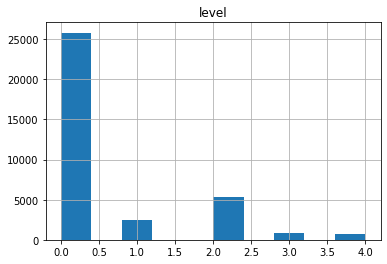

In [0]:
df.hist()

In [0]:
#dictionary for level of images
level = {}
for i in range(df.shape[0]):
  level[df['image'][i]] = df['level'][i]

In [0]:
images = []
label = []

In [0]:
# reading images
#i=0
for filename in os.listdir("train/"):
  img = cv2.imread(os.path.join("train/",filename))
  img = cv2.resize(img,(32,32))
  #i+=1
  #print(i)
  if img is not None:
    images.append(img)
    label.append(level[filename[:-5]])

In [0]:
X,y = images, label

In [0]:
X = np.array(X)
y = np.array(y)

In [0]:
#splitting data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# **DenseNet201**

In [0]:
#model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential,Model,load_model
img_height,img_width = 32,32
num_classes = 5
base_model = applications.densenet.DenseNet201(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

74842112/74836368 [==============================] - 1s 0us/step


In [0]:
#Optimizer
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer= adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
# model layers
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.47441 to fit



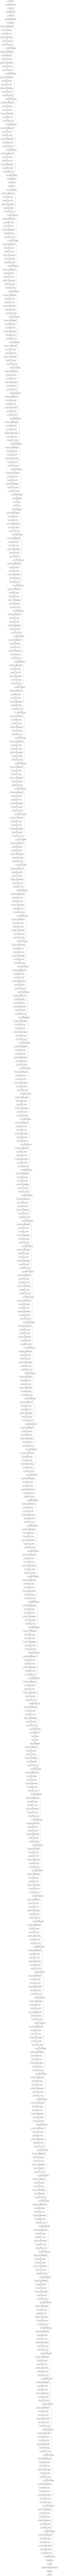

In [0]:
#flowchart of model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [0]:
#training
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

In [0]:
#testing
loss, acc = model.evaluate(X_test,y_test)
print("loss: ",loss)
print("accuracy: ",acc)

330/330 [==============================] - 59s 179ms/step - loss: 0.8358 - accuracy: 0.7394
loss:  0.8358302116394043
accuracy:  0.7394192218780518


In [0]:
#Classification Matrices
from sklearn.metrics import accuracy_score, classification_report
y_pred  =np.argmax(model.predict(X_test),axis=1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy on Test Data: 0.74%
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      7791
           1       0.00      0.00      0.00       701
           2       0.31      0.01      0.02      1572
           3       0.00      0.00      0.00       280
           4       0.00      0.00      0.00       194

    accuracy                           0.74     10538
   macro avg       0.21      0.20      0.17     10538
weighted avg       0.59      0.74      0.63     10538



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


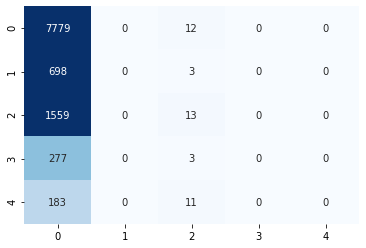

In [0]:
#confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = X_test.shape[0]//16)